In [3]:
import random
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np

In [4]:

def load(file):
    cities = []
    with open(file, 'r') as f:
        for line in f:
            data = line.split()
            city_num = int(data[0])-1
            x = float(data[1])
            y = float(data[2])
            demand = float(data[3])
            ready_time = float(data[4])
            due_time = float(data[5])
            
            city = {'city_num' : city_num, 'x' : x, 'y' : y, 'demand' : demand, 'ready_time' : ready_time, 'due_time' : due_time}
            cities.append(city)
            
    return cities   

In [5]:
input1 = load('resources/input_1.txt')
# for city in input1:
#     print(city)
input2 = load('resources/input_2.txt')
input3 = load('resources/input_3.txt')

In [6]:
class Individual:
    def __init__(self, data, capacity, num_of_vehicles, num_of_customers, service_time):
        self.num_of_vehicles = num_of_vehicles
        self.num_of_customers = num_of_customers
        self.depot = data[0]
        self.data = data
        self.capacity = capacity
        self.service_time = service_time
        self.alpha = 2
        self.beta = 5
        self.solution = self.generate_solution_random()
        self.fitness = self.calc_fitness()

    def __len__(self) -> int:
        return len(self.solution)
    
    def calc_distance(self, customer1, customer2):
        return math.sqrt((customer1["x"] - customer2["x"])**2 + (customer1["y"] - customer2["y"])**2)

    def generate_solution(self):
        pass
    
    def generate_solution_random(self):
        routes = [[] for _ in range(self.num_of_vehicles)]
        remaining = set(range(1, self.num_of_customers + 1))

        
        while remaining:
            customer_index = random.choice(list(remaining))
            id = 0
            for j in range(self.num_of_vehicles):
                if self.route_is_valid(routes[j], customer_index):
                    routes[j].append(customer_index)
                    remaining.remove(customer_index)
                    id = 1
                    break
            if id == 0: #ako nije pronadjena feasible ruta, restartujemo alg
                routes = [[] for _ in range(self.num_of_vehicles)]
                remaining = set(range(1, self.num_of_customers + 1))
        
        chromosome = []
        i = 1
        for x in routes:
            for c in x:
                chromosome.append(c)
            chromosome.append(self.num_of_customers + i)
            i += 1
                
        #chromosome.pop(-1)
        for c in reversed(chromosome):
            if c > 100:
                chromosome.pop(-1)
            else:
                break


        return chromosome


        
    def route_is_valid(self, route, customer_index):
        fitness, current_time, remaining_capacity = self.route_fitness(route)
        if not route:
            return True
        if fitness == float('inf') or current_time == float('inf') or remaining_capacity < self.data[customer_index]["demand"] or current_time + self.calc_distance(self.data[route[-1]], self.data[customer_index]) > self.data[customer_index]["due_time"]:
            return False
        
        return True


    
    def generate_solution_nearest_neighbour(self):
        routes = [[] for _ in range(self.num_of_vehicles)]
        remaining = set(range(1, self.num_of_customers+1))
        selection_value = [(i,max(self.calc_distance(self.depot, self.data[i]), self.data[i]["ready_time"])) for i in range(1, self.num_of_customers+1) if self.data[i]["demand"] < self.capacity]
        selection_value.sort(key = lambda x: x[1])
        j = 0
        while remaining:
            if random.random() < 0.25:
                customer_index = random.choice(selection_value)[0]
            else:
                customer_index = selection_value[0][0] # najmanji selection value 
       
            routes[j].append(customer_index)
            remaining.remove(customer_index)
            fitness, time, remaining_capacity = self.route_fitness(routes[j])
            selection_value = [(r, max(self.calc_distance(self.data[routes[j][-1]], self.data[r]), self.data[r]["ready_time"] - time)) for r in remaining if time + self.calc_distance(self.data[routes[j][-1]], self.data[r]) < self.data[r]["due_time"] and remaining_capacity >= self.data[r]["demand"]]
            selection_value.sort(key = lambda x: x[1])

            if not selection_value:
                j += 1
                selection_value = [(i,max(self.calc_distance(self.depot, self.data[i]), self.data[i]["ready_time"])) for i in remaining if self.data[i]["demand"] < self.capacity]
                selection_value.sort(key = lambda x: x[1])
                if j == self.num_of_vehicles:
                    routes = [[] for _ in range(self.num_of_vehicles)]
                    remaining = set(range(1, self.num_of_customers+1))
                    selection_value = [(i,max(self.calc_distance(self.depot, self.data[i]), self.data[i]["ready_time"])) for i in range(1, self.num_of_customers+1) if self.data[i]["demand"] < self.capacity]
                    selection_value.sort(key = lambda x: x[1])
                    j = 0

        chromosome = []
        i = 1
        for x in routes:
            for c in x:
                chromosome.append(c)
            chromosome.append(self.num_of_customers + i)
            i += 1
                
        #chromosome.pop(-1)
        
        for c in reversed(chromosome):
            if c > 100:
                chromosome.pop(-1)
            else:
                break


        return chromosome




    def generate_solution_sweep(self):
        pass

    def route_fitness(self, route):
        if not route:
            return 0, 0, self.capacity
        
        fitness = 0
        current_time = 0
        current_node = self.depot
        remaining_capacity = self.capacity 
        for r, i in zip(route, range(len(route))):

            if current_time + self.calc_distance(current_node, self.data[r]) > self.data[r]["due_time"]:
                current_time += ((current_time + self.calc_distance(current_node, self.data[r])) - self.data[r]["due_time"])*self.alpha
            if remaining_capacity < self.data[r]["demand"]:
                current_time += (self.data[r]["demand"] - remaining_capacity)*self.beta
            current_time += max(self.calc_distance(current_node, self.data[r]), self.data[r]["ready_time"] - current_time) + self.service_time
            current_node = self.data[r]
            remaining_capacity -= self.data[r]["demand"]
            
        fitness += current_time + self.calc_distance(self.data[route[-1]], self.depot)
        
        return fitness, current_time, remaining_capacity
    
    def get_routes(self, solution):
        routes = []
        route = []
        # all routes except for the last route
        for node in solution:
            if node <= self.num_of_customers:
                route.append(node)
            else:
                if route is not []:
                    routes.append(route)
                route = []

        # last route
        if route is not []:
            routes.append(route)

        return routes
    
    def calc_fitness(self):
        routes = self.get_routes(self.solution)
        
        fitness = 0
        for route in routes:
            if len(route) == 0:
                continue
            f, _, _ = self.route_fitness(route)
            fitness += f
            
            
        return fitness

        # distance ~ isto sto i vreme 
        # vreme na putu + vreme cekanja (ako ga ima) + service time 
        # vreme cekanja = 0 ili ready time - arrival time

        # Di + distance(i,j) + wait time

        # penalizujemo resenja koja ne ispunjavaju uslove za time window

    def is_feasable(self, sol):
        # ponavljanje gradova
        # koriscenje vise vozila nego sto postoji 
        # if len(sol) > self.num_of_vehicles:
        #     print("more vehicles than available violation")
        #     return False

        if sum(1 for x in sol if len(x) != 0) > self.num_of_vehicles:
            print("more vehicles than available violation")
            return False
        

        visited_customers = [False for _ in range(self.num_of_customers)]

        for route in sol:
            current_time = 0
            current_node = 0
            remaining_capacity = self.capacity
            for c in route:
                if remaining_capacity < self.data[c]["demand"]:
                #if remaining_capacity < self.data[c]["demand"]:
                    print("capacity violation")
                    return False
                elif current_time + self.calc_distance(self.data[current_node], self.data[c]) > self.data[c]["due_time"]:
                    print("time window violation ")
                    print(route)
                    return False
                else:
                    current_time += max(self.calc_distance(self.data[current_node], self.data[c]), self.data[c]["ready_time"] - current_time) + self.service_time
                    current_node = c
                    remaining_capacity -= self.data[c]["demand"]
                    if visited_customers[c-1]:
                        print("visiting same customer multiple times violation")
                        return False
                    visited_customers[c-1] = True
        if not all(visited_customers):
            print("not all customers visited violation")
        return all(visited_customers)
        

In [7]:
x = Individual(input1, 200, 50, 100, 10)
print(x.solution)
print(x.is_feasable(x.get_routes(x.solution)))
y = Individual(input1, 200, 50, 100, 10)


[26, 100, 101, 22, 91, 58, 102, 62, 74, 25, 103, 69, 53, 56, 89, 104, 36, 3, 48, 105, 88, 55, 77, 106, 19, 1, 80, 107, 73, 54, 70, 108, 52, 84, 96, 60, 93, 109, 27, 85, 97, 13, 110, 83, 44, 6, 4, 111, 45, 61, 10, 32, 112, 28, 81, 34, 35, 113, 33, 99, 43, 114, 39, 66, 115, 51, 24, 116, 98, 40, 37, 17, 117, 64, 90, 20, 118, 47, 8, 46, 119, 23, 41, 68, 120, 30, 79, 50, 121, 87, 57, 122, 12, 78, 123, 82, 49, 124, 42, 21, 94, 125, 63, 71, 9, 126, 95, 15, 127, 14, 75, 128, 67, 129, 5, 16, 86, 130, 31, 7, 131, 29, 132, 2, 38, 133, 76, 134, 18, 135, 92, 11, 136, 72, 137, 65, 138, 59]
True


In [8]:
x.solution == y.solution

False

# Selection

In [9]:
def random_selection(population):
    return random.choice(population)

In [10]:
def tournament_selection(population, tournament_size):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key = lambda x: x.fitness)

In [11]:
def roulette_selection(population):
    total_fitness = sum([individual.fitness for individual in population])
    selection_probs = [individual.fitness / total_fitness for individual in population]
    return random.choices(population, weights=selection_probs)[0]

In [12]:
def rang_selection(population):
    n = len(population)
    rang_sum = n * (n+1) / 2
    selection_probs = []
    for rang, _ in enumerate(sorted(population, key=lambda x: x.fitness), 1):
        selection_probs.append(rang / rang_sum)
        
    return random.choices(population, weights=selection_probs)[0]

In [13]:
def selection(param, population):
    if param["tournament_size"] is not None:
        return param["selection"](population, param["tournament_size"])
    else:
        return param["selection"](population)

In [14]:
class Example_Individual:
    def __init__(self, fitness, name):
        self.fitness = fitness
        self.name = name

example_population = [Example_Individual(fitness=0.8, name='A'), 
                      Example_Individual(fitness=0.6, name='B'), 
                      Example_Individual(fitness=0.7, name='C'),
                      Example_Individual(fitness=0.8, name='D'), 
                      Example_Individual(fitness=0.9, name='E')]

print(random_selection(example_population).name)
print(tournament_selection(example_population, 3).name)
print(roulette_selection(example_population).name)
print(rang_selection(example_population).name)

A
A
C
E


# Crossover

In [15]:
def order_crossover(parent1, parent2, child1, child2):
    def oc(p1, p2, ch):
        lb, ub = sorted(random.sample(range(len(p1) + 1), 2))
        ch[lb:ub] = p1[lb:ub]

        j = 0
        for i in range(len(p2)):
            if j == lb:
                j = ub + 1

            if j >= len(ch):
                break

            if p2[i] not in ch:
                ch[j] = p2[i]
                j = j + 1 

        return ch
    
    
    child1 = oc(parent1, parent2, child1)
    child2 = oc(parent2, parent1, child2)
    
    return child1, child2

In [16]:
def partially_mapped_crossover(parent1, parent2, child1, child2):
    cutoff_1, cutoff_2 = sorted(random.sample(range(len(parent1) + 1), 2))
    
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    child1[cutoff_1:cutoff_2] = parent2[cutoff_1:cutoff_2]
    child2[cutoff_1:cutoff_2] = parent1[cutoff_1:cutoff_2]

   

    middle_map = {}
    for a, b in zip (child1[cutoff_1:cutoff_2], child2[cutoff_1:cutoff_2]):
        middle_map[a] = middle_map.get(a, 0) + 1
        middle_map[b] = middle_map.get(b, 0) + 1
        
    mapping_order = []
    for key, value in middle_map.items():
        if value != 2:
            mapping_order.append(key)
            
    def find_all_occurrences(lst, item):
        return [i for i, x in enumerate(lst) if x == item]    
          
    def replace_a_b(x_pos, y, child, cutoff_1, cutoff_2):
        for i in x_pos:
            if i not in range(cutoff_1, cutoff_2):
                child[i] = y
                break 
                   
        return child
        
    def replace_a_b_child(a, a_pos, b, b_pos, child, cutoff_1, cutoff_2):
        if len(a_pos) != 0:
             return replace_a_b(a_pos, b, child, cutoff_1, cutoff_2)
        else:
            return replace_a_b(b_pos, a, child, cutoff_1, cutoff_2)
        
    for i in range(0, len(mapping_order)-1, 2):
        a = mapping_order[i]
        b = mapping_order[i+1]

        a_child1_positions = find_all_occurrences(child1, a)
        a_child2_positions = find_all_occurrences(child2, a)
        
        
        b_child1_positions = find_all_occurrences(child1, b)
        b_child2_positions = find_all_occurrences(child2, b)
        
        child1 = replace_a_b_child(a, a_child1_positions, b, b_child1_positions, child1, cutoff_1, cutoff_2)
        child2 = replace_a_b_child(a, a_child2_positions, b, b_child2_positions, child2, cutoff_1, cutoff_2)

    return child1, child2

[1 | 2 3 4 | 5]  
[5 | 4 3 1 | 2]   

[1 | 4 3 1 | 5]   
[5 | 2 3 4 | 2]   

4-2, 3-3, 1-4

1: 1   
2: 1   
3: 2   
4: 2  
1 -> 2  

[2 | 1 3 4 | 5]    
[5 | 2 3 4 | 1]    

In [17]:
def best_route_better_adjustment_crossover(individual, parent1, parent2, child1, child2):
    # n/2 best from parent1 into first n/2 of child1
    # the rest elements are from parent2 
    # the positions of vehicles are fixed
        
    def create_child(p1, p2, ch1):
        p1_routes = individual.get_routes(p1)
        p1_sorted = sorted(p1_routes, key = lambda route: individual.route_fitness(route))

        # copy half of the best routes from parent1 to child 1
        best_routes_index = 0
        i = 0
        node_index = 0
        while best_routes_index <= len(p1_sorted) / 2:
            node = ch1[node_index]
            if node <= individual.num_of_customers and i < len(p1_sorted[best_routes_index]):
                ch1[node_index] = p1_sorted[best_routes_index][i]
                i = i + 1
            else:
                best_routes_index = best_routes_index + 1
                i = 0

            node_index = node_index + 1

        # copy elements from parent2 that aren't in child so far
        p2_index = 0
        while node_index < len(ch1):
            node = ch1[node_index]
            if node <= individual.num_of_customers:
                p2_node = p2[p2_index]
                if p2_node > individual.num_of_customers:
                    p2_index = p2_index + 1
                    p2_node = p2[p2_index]
                
                if p2_node not in ch1[:node_index]:
                    ch1[node_index] = p2_node
                p2_index = p2_index + 1

            node_index = node_index + 1
            
        return ch1
    
    child1 = create_child(parent1, parent2, child1)
    child2 = create_child(parent2, parent1, child2)
    return child1, child2

In [18]:
def crossover(param, parent1, parent2, child1, child2):
    if param["individual"] is not None:
        return param["crossover"](param["individual"], parent1, parent2, child1, child2)
    else:
        return param["crossover"](parent1, parent2, child1, child2)

# Mutation

In [19]:
def swap_mutation(individual):
    l, r = sorted(random.sample(range(len(individual)), 2))
    individual[l], individual[r] = individual[r], individual[l]
    
    return individual

In [20]:
def invert_mutation(individual):
    l, r = sorted(random.sample(range(len(individual) + 1), 2))
    chosen = individual[l:r]
    chosen.reverse()
    individual[l:r] = chosen
    
    return individual

In [21]:
def shaking_mutation(individual):
    l, r = sorted(random.sample(range(len(individual) + 1), 2))
    chosen = individual[l:r]
    random.shuffle(chosen)
    individual[l:r] = chosen
    
    return individual

In [22]:
def mutation(param, individual, mutation_prob):
    if random.random() < mutation_prob:
        individual = param(individual)
        
    return individual

# Fix solution



    "An adaptive large neighborhood search heuristic for the vehicle routing problem with time windows" by C. R. Castro, M. G. C. Resende, and A. A. Viana. (2012)
        This paper presents an adaptive large neighborhood search (ALNS) heuristic for the VRPTW, which includes an insertion-based repair mechanism.

    "A hybrid genetic algorithm for the vehicle routing problem with time windows" by Y. Liang and J. Zhang. (2006)
        The authors propose a hybrid genetic algorithm that integrates an insertion-based repair method for the VRPTW.

    "An adaptive memory algorithm for a class of vehicle routing problems with time windows" by M. Gendreau, G. Laporte, and F. Semet. (2006)
        This paper introduces an adaptive memory algorithm for vehicle routing problems, including the VRPTW, which utilizes insertion-based repair techniques.

    "An adaptive algorithm for the vehicle routing problem with time windows" by M. Gendreau, G. Laporte, and F. Semet. (2002)
        The authors propose an adaptive algorithm for the VRPTW that employs insertion-based repair strategies to improve solution quality.

    "An adaptive large neighborhood search heuristic for the vehicle routing problem with time windows" by T. G. Crainic, M. Gendreau, and J. Potvin. (2000)
        This paper introduces an adaptive large neighborhood search heuristic for the VRPTW, which includes insertion-based repair procedures to handle infeasible solutions.

In [ ]:
def insertion_based_repair():
    pass



# Genetic algorithm

In [23]:
def genetic_algorithm(params):
    
    data = params["data"]
    capacity = params["capacity"]
    num_of_vehicles = params["num_of_vehicles"]
    service_time = params["service_time"]
    population_size = params["population_size"]
    num_generations = params["num_generations"]
    elitism_size = params["elitism_size"]
    tournament_size = params["tournament_size"]
    selection_params = params["selection"]
    crossover_param = params["crossover"]
    mutation_params = params["mutation"]
    mutation_prob = params["mutation_prob"]
    
    population = [Individual(data, capacity, num_of_vehicles, len(data)-1, service_time ) for _ in range(population_size)]
    print([x.fitness for x in population])
    new_population = deepcopy(population)
  
    crossover_params = { "crossover" : crossover_param, 
                         "individual" : population[0] if crossover_param.__name__ == "best_route_better_adjustment_crossover" else None }
    best_solutions = []
    for i in range(num_generations):
        population.sort(key = lambda x: x.fitness)
        print([x.fitness for x in population])
        best_solutions.append(population[0])
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(selection_params, population)
            parent2 = selection(selection_params, population)
            
            while(parent1 == parent2):
                parent2 = selection(selection_params, population)

            
            new_population[j].solution, new_population[j+1].solution = crossover(crossover_params, 
                                                                                 parent1.solution, 
                                                                                 parent2.solution, 
                                                                                 new_population[j].solution, 
                                                                                 new_population[j+1].solution)
                
            
            new_population[j].solution = mutation(mutation_params, new_population[j].solution, mutation_prob)
            new_population[j+1].solution = mutation(mutation_params, new_population[j+1].solution, mutation_prob)

            insertion_based_repair(new_population[j])
            insertion_based_repair(new_population[j+1])

            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()

        population = deepcopy(new_population)
        
    
    return min(population, key = lambda x: x.fitness), best_solutions

In [ ]:
POPULATION_SIZE = 1000
ELITISIM_SIZE = 100
MUTATION_PROB = 0.1
TOURNAMENT_SIZE = 300
NUM_GENERATIONS = 100
CAPACITY = 300
SELECTION = rang_selection
CROSSOVER = order_crossover
MUTATION = shaking_mutation
NUM_OF_VEHICLES = 50
SERVICE_TIME = 10

params = {
    "data" : input1,
    "population_size" : POPULATION_SIZE,
    "elitism_size" : ELITISIM_SIZE,
    "mutation_prob" : MUTATION_PROB,
    "tournament_size" : TOURNAMENT_SIZE,
    "num_generations" : NUM_GENERATIONS,
    "capacity" : CAPACITY,
    "selection" : { "selection" : SELECTION, 
                    "tournament_size" : TOURNAMENT_SIZE if SELECTION.__name__ == "tournament_selection" else None
                  },
    "crossover" : CROSSOVER,
    "mutation" : MUTATION,
    "num_of_vehicles" : NUM_OF_VEHICLES,
    "service_time" : SERVICE_TIME
}

ga_order_crossover, best_solutions_order_crossover = genetic_algorithm(params)

# params["crossover"] = partially_mapped_crossover

# ga_pmc, best_solutions_pmc = genetic_algorithm(params)

# params["crossover"] = best_route_better_adjustment_crossover

# ga_brbac, best_solutions_brbac = genetic_algorithm(params)


In [ ]:
ga_order_crossover.is_feasable(ga_order_crossover.get_routes(ga_order_crossover.solution))


True

In [ ]:
print(sum(1 for x in ga_order_crossover.get_routes(ga_order_crossover.solution) if len(x) != 0))
print(len(x.get_routes(x.solution)))
print(ga_order_crossover.fitness)



32
35
5109.747377460852


In [ ]:
ga_pmc.is_feasable(ga_pmc.get_routes(ga_pmc.solution))

True

In [ ]:
ga_brbac.is_feasable(ga_brbac.get_routes(ga_brbac.solution))

True

In [ ]:
ga_brbac.solution == ga_pmc.solution

False

egzaktan, grafovi, viseciljna, reference, prezentacija i pdf



# Graphs

In [ ]:
def plot_customers(x_coordinates, y_coordinates, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coordinates[1:], y_coordinates[1:], color='red', label='Customers')
    plt.scatter(x_coordinates[0], y_coordinates[0], color='blue', label='Depot') 
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Customer Coordinates for ' + dataset_name)
    plt.legend()
    plt.grid(True)
    plt.show()

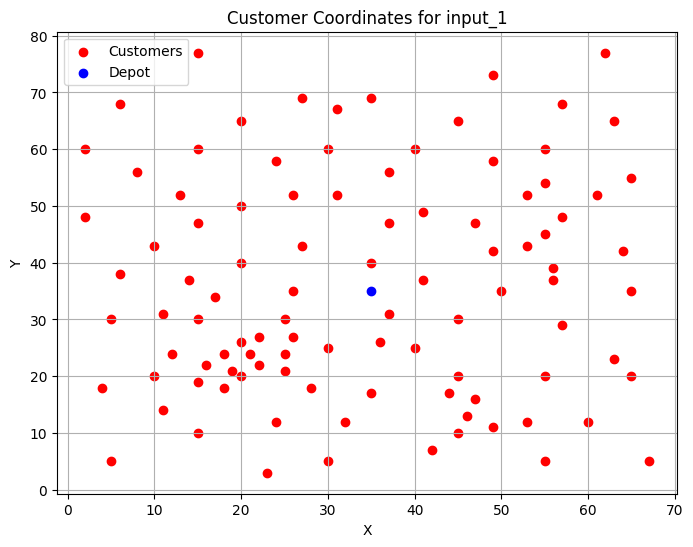

In [ ]:
x_input1 = [x["x"] for x in input1]
y_input1 = [x["y"] for x in input1]

x_input2 = [x["x"] for x in input2]
y_input2 = [x["y"] for x in input2]

x_input3 = [x["x"] for x in input3]
y_input3 = [x["y"] for x in input3]


plot_customers(x_input1, y_input1, "input_1")


In [ ]:
#Best solution routes 
def plot_best_solution(x, title):
    plt.figure(figsize=(8, 6))
    routes = x.get_routes(x.solution)
    for route in routes:
        x_points  = np.array([x.depot["x"]])
        x_points = np.append(x_points, [x.data[i]["x"] for i in route], axis = 0)
        x_points = np.append(x_points, [x.depot["x"]], axis = 0)
        y_points  = np.array([x.depot["y"]])
        y_points = np.append(y_points, [x.data[i]["y"] for i in route], axis = 0)
        y_points = np.append(y_points, [x.depot["y"]], axis = 0)
        

        plt.plot(x_points, y_points)
    
    plt.title(title)
    plt.show


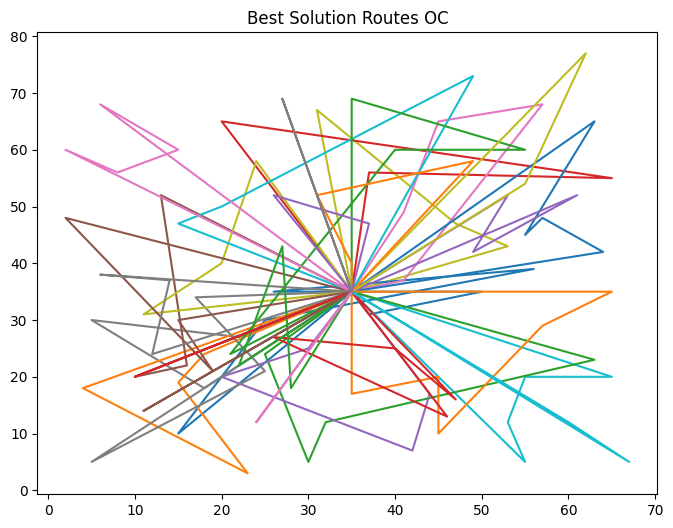

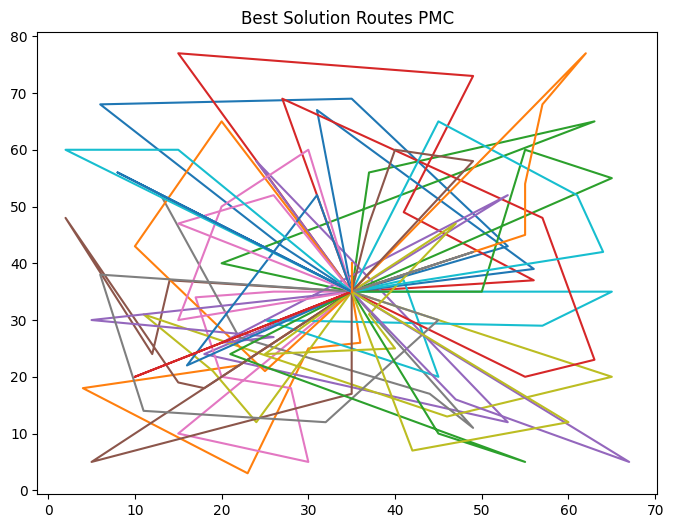

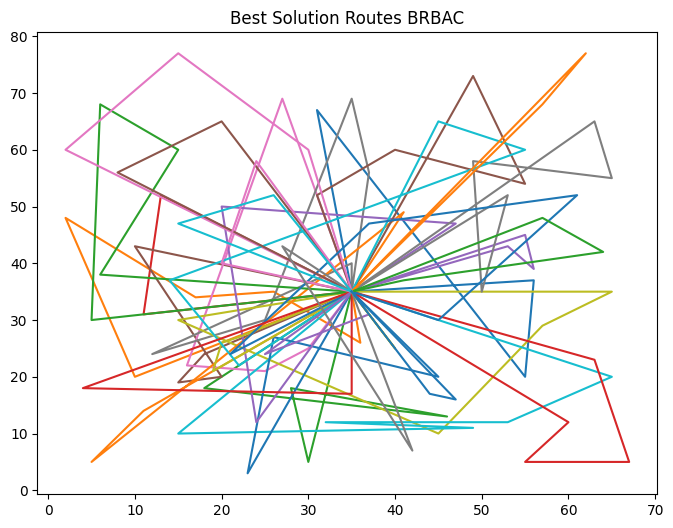

In [ ]:
plot_best_solution(ga_order_crossover, "Best Solution Routes OC")
plot_best_solution(ga_pmc, "Best Solution Routes PMC")
plot_best_solution(ga_brbac, "Best Solution Routes BRBAC") 

In [ ]:
def best_solution_evolution(solutions, title, info):
    plt.figure(figsize=(8, 6))
    y_points = [[] for _ in range(len(solutions))]
    i = 0
    for solution in solutions:
        y_points[i] = [x.fitness for x in solution]
        i+=1
    
    for i,y in enumerate(y_points):
        plt.plot(np.array(y), label = info[i])
    plt.title(title)
    plt.ylabel("fitness")
    plt.xlabel("generation")
    plt.legend()
    plt.show()

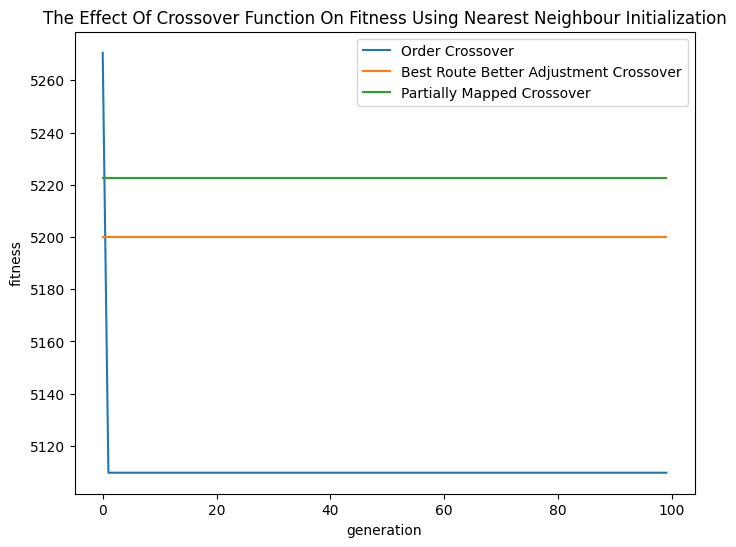

In [ ]:
best_solution_evolution([best_solutions_order_crossover,best_solutions_brbac, best_solutions_pmc], "The Effect Of Crossover Function On Fitness Using Nearest Neighbour Initialization", ["Order Crossover", "Best Route Better Adjustment Crossover", "Partially Mapped Crossover"])